In [19]:
import numpy as np
from pathlib import Path
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 160
plt.rcParams['legend.fontsize'] = 'large'

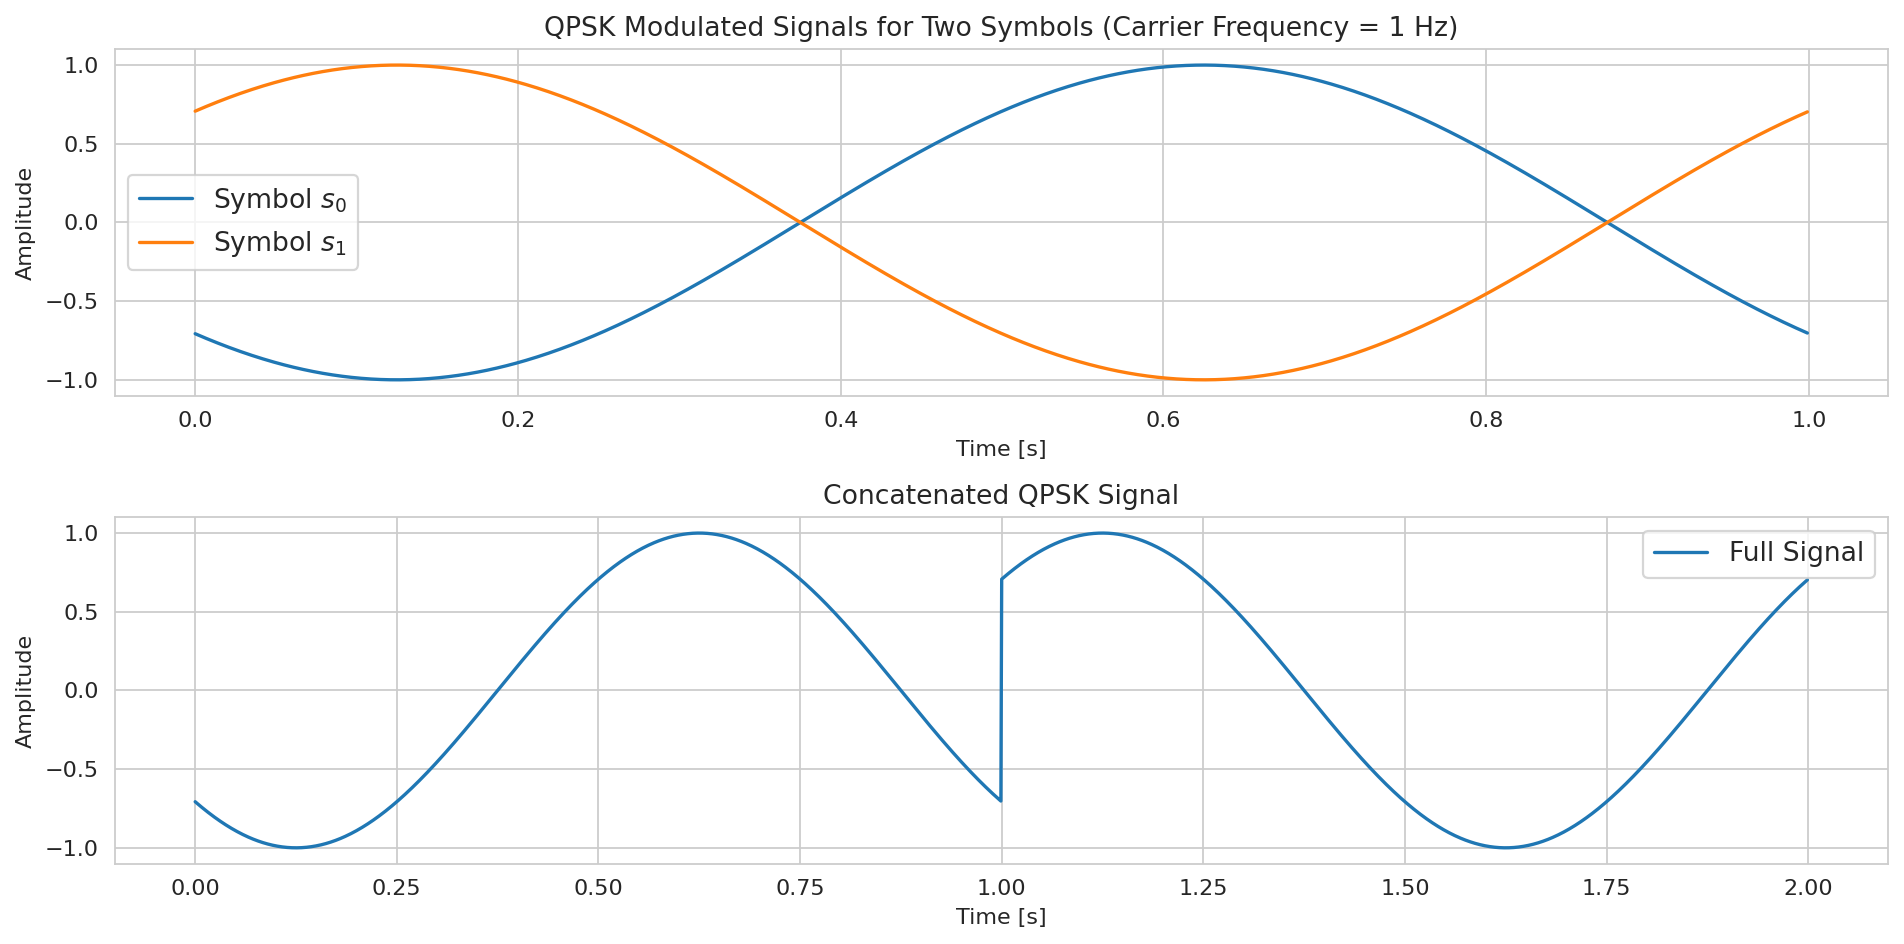

In [20]:
f_c = 1  # Hz
T_s = 1  # seconds, symbol duration
fs = 1000  # sampling frequency (samples per second)
t = np.linspace(0, T_s, int(fs * T_s), endpoint=False)  # time vector for one symbol

# Define QPSK symbols based on the chosen mapping:
# Mapping:
#  01 -> s0 = 1/sqrt(2)*(-1 + j)   --> symbol 0 (first symbol)
#  10 -> s1 = 1/sqrt(2)*(1 - j)    --> symbol 1 (second symbol)
s0 = (1 / np.sqrt(2)) * (-1 + 1j)
s1 = (1 / np.sqrt(2)) * (1 - 1j)

# Retrieve the in-phase (I) and quadrature (Q) components:
I0, Q0 = s0.real, s0.imag
I1, Q1 = s1.real, s1.imag

# Generate the QPSK modulated signals for each symbol:
# x(t) = I*cos(2*pi*f_c*t) - Q*sin(2*pi*f_c*t)
x0 = I0 * np.cos(2 * np.pi * f_c * t) - Q0 * np.sin(2 * np.pi * f_c * t)
x1 = I1 * np.cos(2 * np.pi * f_c * t) - Q1 * np.sin(2 * np.pi * f_c * t)

# Create a time vector for the full signal (concatenating the two symbols)
t_full = np.linspace(0, 2 * T_s, 2 * int(fs * T_s), endpoint=False)
x_full = np.concatenate([x0, x1])

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot individual symbols
plt.subplot(2, 1, 1)
plt.plot(t, x0, label=r'Symbol $s_0$')
plt.plot(t, x1, label=r'Symbol $s_1$')
plt.title('QPSK Modulated Signals for Two Symbols (Carrier Frequency = 1 Hz)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Plot concatenated full signal
plt.subplot(2, 1, 2)
plt.plot(t_full, x_full, label='Full Signal')
plt.title('Concatenated QPSK Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

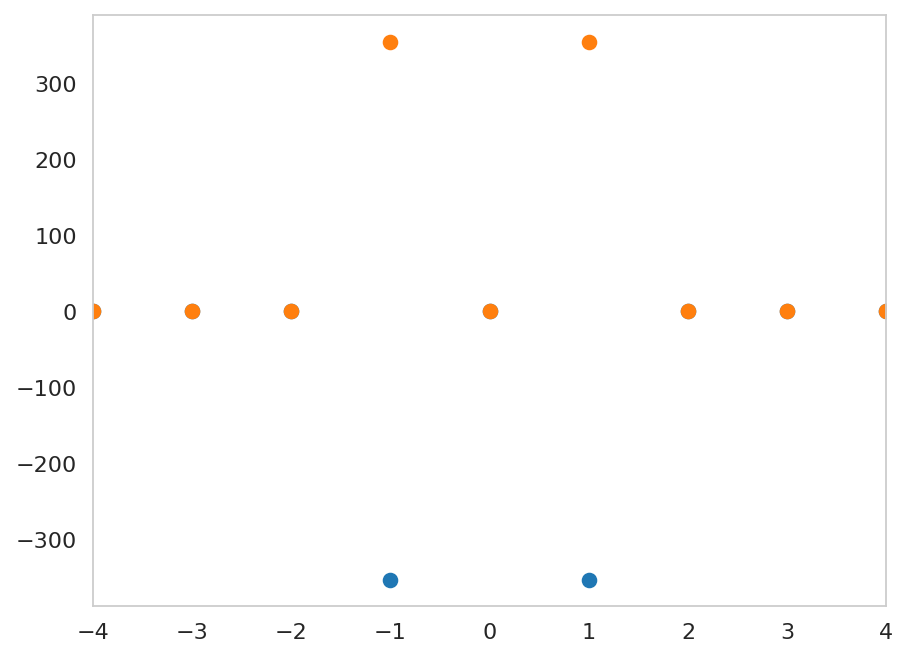

In [22]:
x_half = x_full[:len(x_full) // 2]
x_half_2 = x_full[len(x_full) // 2:]
plt.scatter(np.fft.fftfreq(len(x_half), 1 / len(x_half)), np.fft.fft(x_half).real)
plt.scatter(np.fft.fftfreq(len(x_half_2), 1 / len(x_half)), np.fft.fft(x_half_2).real)
plt.xlim(-4, 4)
plt.grid()
# np.fft.fftshift()

800

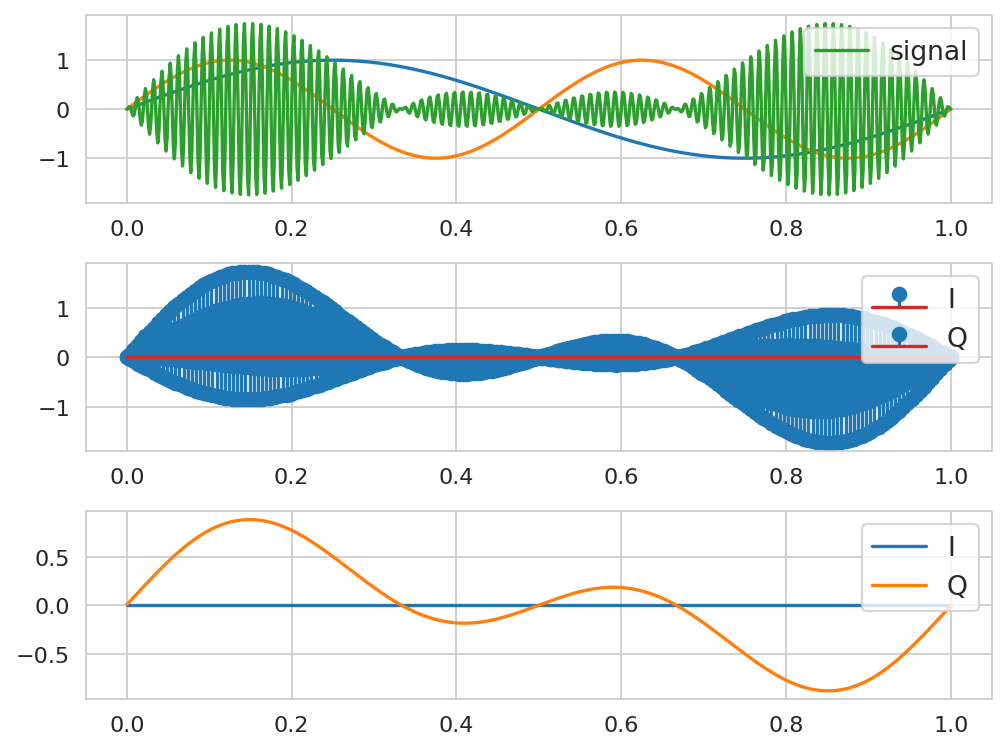

In [31]:
t = np.linspace(0, 1, 800)

f_c = 100

sin_x = np.sin(2 * np.pi * t)
sin_15x = np.sin(3 * np.pi * t)
sin_2x = np.sin(4 * np.pi * t)
sin_200x = np.sin(f_c * 2 * np.pi * t)

r = 1  # the data is transmitted over a carrier frequency. We do not need to sample at the same rate as the data is encoded in lower frequencies. We can sample at a lower rate.
# However, the demodulation happens in hardware and is analog. Therefore, we can't downsample in software to simulate this behaviour.
t_recover = t[::r]

signal = ((sin_x + sin_2x) * sin_200x)[::1]
noise = np.random.normal(0, 0.1, len(t))
# signal += noise

plt.subplot(3, 1, 1)
plt.plot(t, sin_x)
plt.plot(t, sin_2x)
plt.plot(t, signal, label='signal')
plt.legend()

plt.subplot(3, 1, 2)

signal = signal[::r]
fft = np.fft.fft(signal)
freq = np.fft.fftfreq(len(t_recover), 1 / len(t_recover))

# plt.xlim(-100, 100)
# plt.ylim(-10, 10)
# plt.plot(freq, fft.real, label='signal')
i = signal * np.cos(2 * np.pi * f_c * t_recover)
q = signal * np.sin(2 * np.pi * f_c * t_recover)
plt.stem(t_recover, i, label='I')
plt.stem(t_recover, q, label='Q')

plt.legend()

plt.subplot(3, 1, 3)
fft_i = np.fft.fft(i)
fft_q = np.fft.fft(q)
# plt.plot(freq, fft_i.real, label='I')
# plt.plot(freq, fft_q.real, label='Q')
# high_pass = np.fft.ifft(fft * np.exp(-1j * 2 * np.pi * 50 * t))
# plt.plot(t, high_pass.real, label='high pass')

freq_mask = np.abs(freq) > 10
fft_i[freq_mask] = 0
fft_q[freq_mask] = 0
plt.plot(t_recover, np.fft.ifft(fft_i).real, label='I')
plt.plot(t_recover, np.fft.ifft(fft_q).real, label='Q')
plt.legend()
plt.tight_layout()
len(fft)
# np.sum(sin_x * sin_2x), np.sum(sin_x * sin_15x), np.sum(sin_2x * sin_15x)

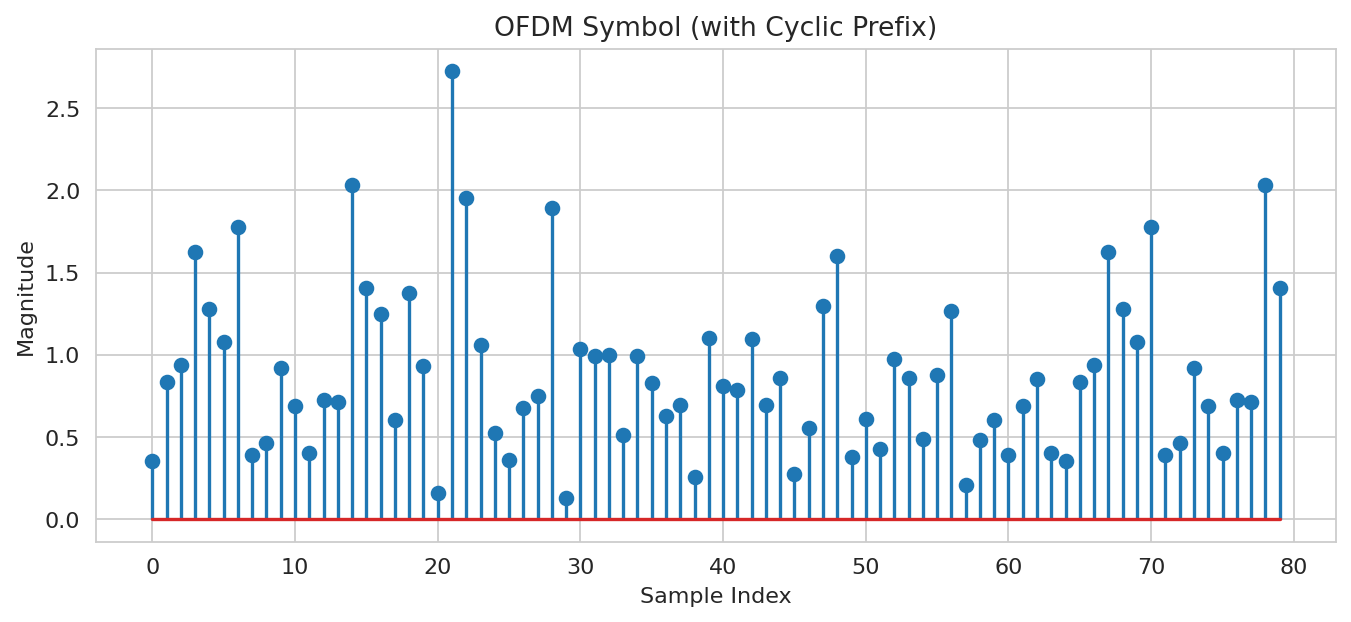

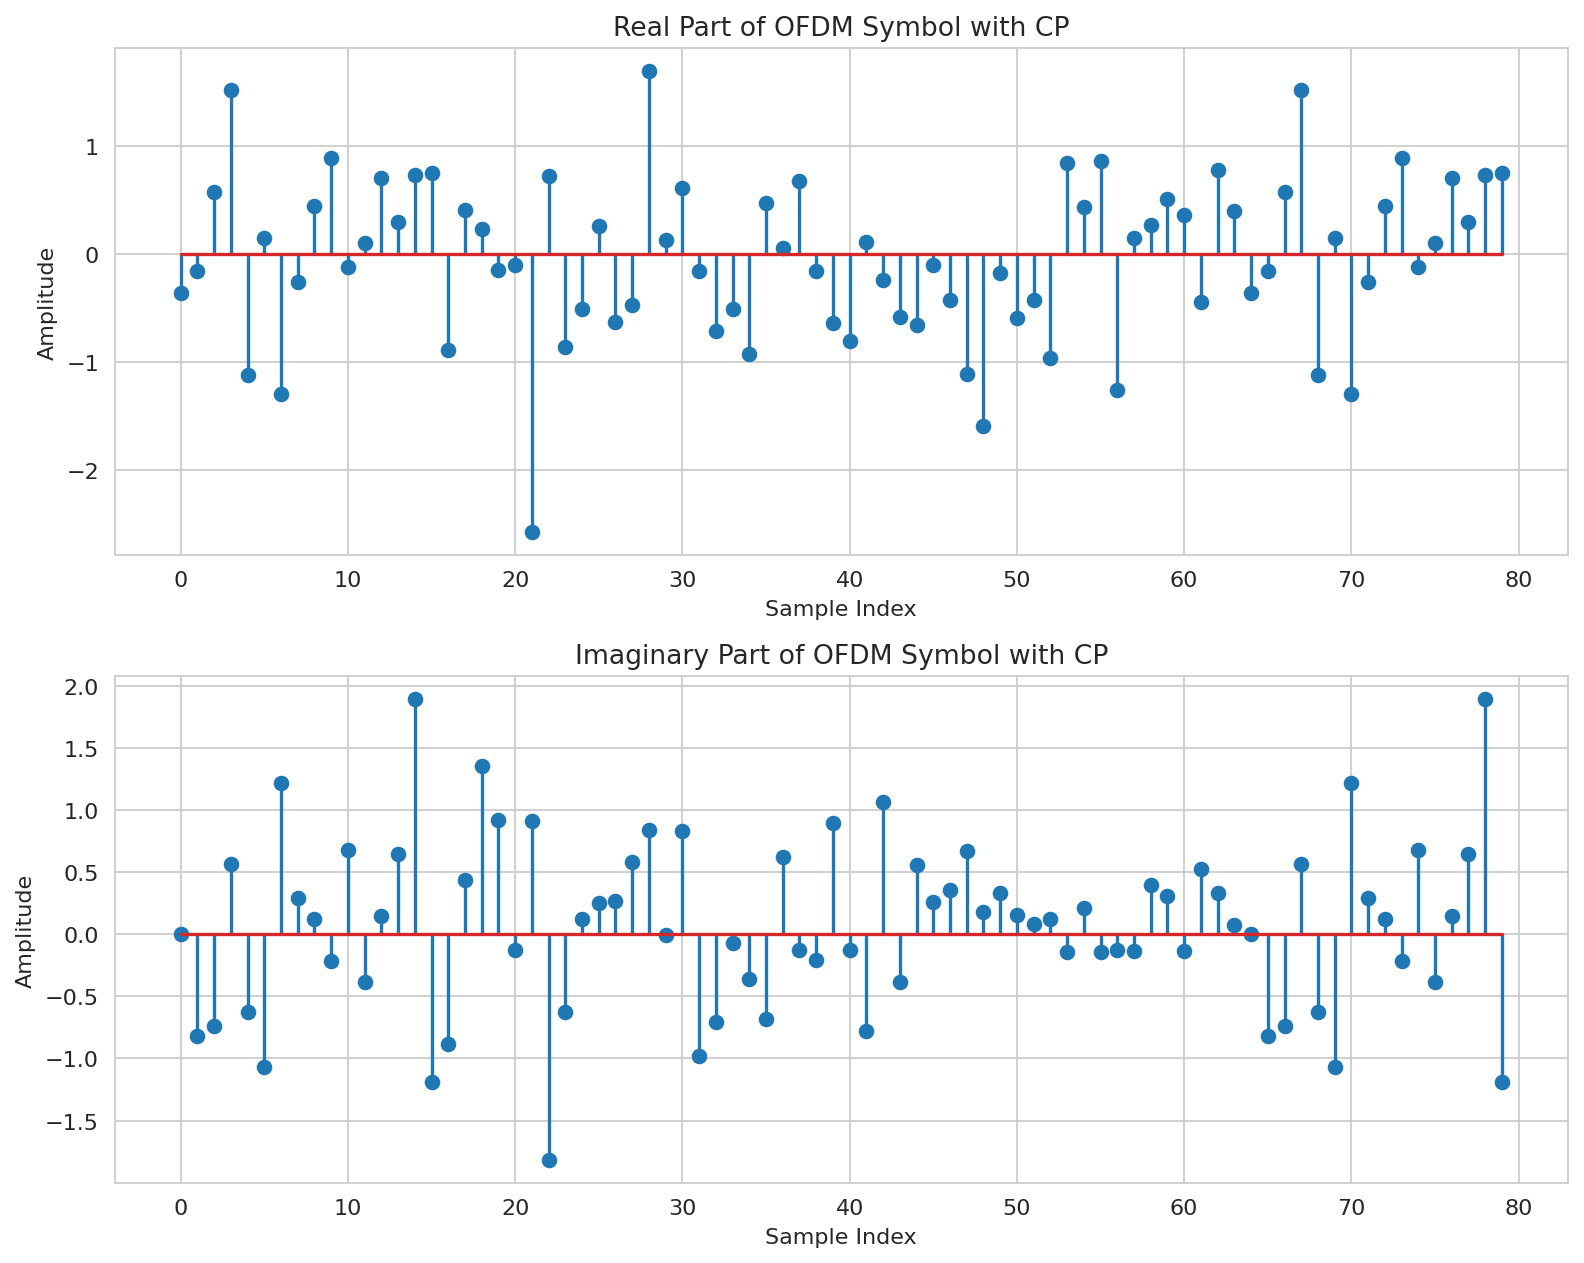

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 64  # Number of subcarriers
L_CP = 16  # Length of cyclic prefix
num_bits = 128  # Total number of bits
num_symbols = num_bits // 2  # Each QPSK symbol carries 2 bits; should equal N (64)

# For demonstration, generate random bits
np.random.seed(42)
bits = np.random.randint(0, 2, num_bits)


# QPSK mapping function
def qpsk_mapper(bit_pair):
    # Use the mapping:
    # 00 ->  1/sqrt(2)*(1+1j)
    # 01 ->  1/sqrt(2)*(-1+1j)
    # 10 ->  1/sqrt(2)*(1-1j)
    # 11 ->  1/sqrt(2)*(-1-1j)
    mapping = {
        (0, 0): 1 / np.sqrt(2) * (1 + 1j),
        (0, 1): 1 / np.sqrt(2) * (-1 + 1j),
        (1, 0): 1 / np.sqrt(2) * (1 - 1j),
        (1, 1): 1 / np.sqrt(2) * (-1 - 1j)
    }
    return mapping[tuple(bit_pair)]


# Map bits to QPSK symbols
symbols = np.array([qpsk_mapper(bits[i:i + 2]) for i in range(0, num_bits, 2)])

# Frequency domain representation: assign one symbol per subcarrier
X = symbols  # Here, X[k] is the symbol for subcarrier k (0 <= k < 64)

# Generate the time-domain OFDM symbol using IFFT
x_time = np.fft.ifft(X, n=N) * np.sqrt(
    N)  # Scaling: some systems use 1/sqrt(N) in IFFT; here we scale up for visualization.

# Add Cyclic Prefix: last L_CP samples appended to the beginning
x_cp = np.concatenate([x_time[-L_CP:], x_time])

# Plot the magnitude of the time-domain OFDM symbol
plt.figure(figsize=(10, 4))
plt.stem(np.abs(x_cp))
plt.xlabel('Sample Index')
plt.ylabel('Magnitude')
plt.title('OFDM Symbol (with Cyclic Prefix)')
plt.grid(True)
plt.show()

# For insight, plot the real and imaginary parts separately.
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.stem(np.real(x_cp))
plt.title('Real Part of OFDM Symbol with CP')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.stem(np.imag(x_cp))
plt.title('Imaginary Part of OFDM Symbol with CP')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()
